In [29]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [11]:
sub_link = os.environ.get("LOCAL_SUB_PATH")
sub_categories = os.listdir(sub_link)
sub_categories

['Cassava green mite', 'Cassava brown spot', 'Cassava mosaic']

In [12]:
def load_images_with_tensorflow(base_directory, sub_categories):
    images = []
    labels = []

    for label in sub_categories:
        directory = os.path.join(base_directory, label)
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                file_path = os.path.join(directory, filename)
                # load image with TensorFlow
                img = tf.io.read_file(file_path)
                img = tf.image.decode_image(img, channels=3)  # convert to tensor and define 3 colors
                img = tf.image.resize(img, [256, 256])

                images.append(img)
                labels.append(label)

    return images, labels


In [13]:
images, labels = load_images_with_tensorflow(sub_link, sub_categories)

In [34]:
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_numeric)

images_array = np.array(images)  # Convertir la liste en un array NumPy
images_normalized = images_array / 255.0

In [35]:
# SPLIT DATA INTO TRAIN AND TESTING SET
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels_one_hot, test_size=0.2, random_state=42)

# Model initialization

In [37]:
from tensorflow.keras import layers
from tensorflow.keras import models

def initialize_model():
    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32, (4,4), input_shape=(256, 256, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second Convolution & MaxPooling
    # model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(2, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(3, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# fit model with earlystopping

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

model_small = initialize_model()

In [39]:
model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 2)                 1048578   
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 1050155 (4.01 MB)
Trainable params: 1050155 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [40]:
es = EarlyStopping(patience = 5, verbose = 2)

history_small = model_small.fit(X_train, y_train,
                    validation_split = 0.3,
                    callbacks = [es],
                    epochs = 100,
                    batch_size = 64)

Epoch 1/100
33/33 [==============================] - 20s 452ms/step - loss: 2.4078 - accuracy: 0.3953 - val_loss: 1.0974 - val_accuracy: 0.3829
Epoch 2/100
33/33 [==============================] - 15s 458ms/step - loss: 1.0954 - accuracy: 0.4102 - val_loss: 1.0954 - val_accuracy: 0.3829
Epoch 3/100
33/33 [==============================] - 13s 405ms/step - loss: 1.0932 - accuracy: 0.4102 - val_loss: 1.0940 - val_accuracy: 0.3829
Epoch 4/100
33/33 [==============================] - 15s 443ms/step - loss: 1.0914 - accuracy: 0.4102 - val_loss: 1.0926 - val_accuracy: 0.3829
Epoch 5/100
33/33 [==============================] - 16s 483ms/step - loss: 1.0897 - accuracy: 0.4102 - val_loss: 1.0915 - val_accuracy: 0.3829
Epoch 6/100
33/33 [==============================] - 15s 441ms/step - loss: 1.0884 - accuracy: 0.4102 - val_loss: 1.0907 - val_accuracy: 0.3829
Epoch 7/100
33/33 [==============================] - 14s 436ms/step - loss: 1.0873 - accuracy: 0.4102 - val_loss: 1.0900 - val_accuracy:

## Plotting History

In [41]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

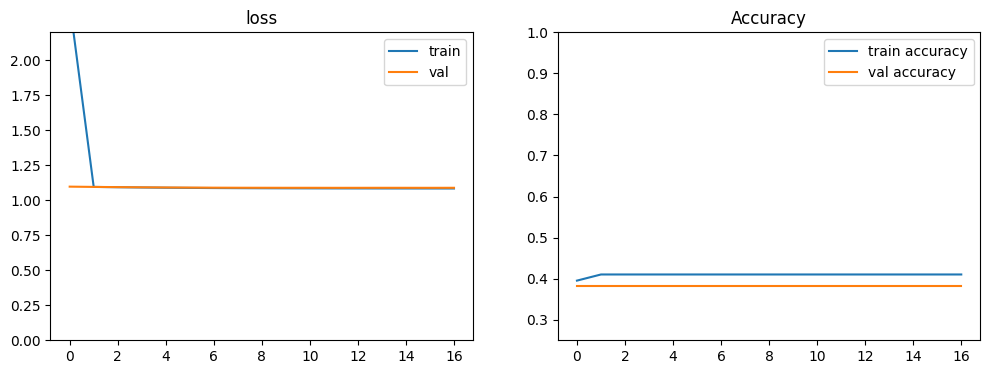

In [42]:
plot_history(history_small)
plt.show()

In [43]:
res = model_small.evaluate(X_test, y_test, verbose = 0)
res

[1.0914268493652344, 0.3927125632762909]

In [49]:
X_test.shape

(741, 256, 256, 3)

In [59]:
image_to_predict = np.expand_dims(X_test[0,:,:,:], axis=0)

In [60]:
model_small.predict(image_to_predict)

1/1 [==============================] - 0s 112ms/step


array([[0.40394   , 0.27807263, 0.31798738]], dtype=float32)